In [29]:
# Implement CBOW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Lambda, Embedding
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gensim.downloader as api
dataset = api.load("text8")

In [3]:
dataset_list = list(dataset)
print(len(dataset_list))
print(dataset_list[0][:200])

1701
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 'interpretations', 'of', 'what', 'this', 'means', 'anarchism', 'also', 'refers', 'to', 'related'

In [4]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(dataset)
sequences = tokenizer.texts_to_sequences(dataset)

In [5]:
print(len(sequences))
longest_sequence = max(sequences, key=len)
print(len(longest_sequence))

1701
9750


In [46]:
# Prepare the training
import random
context_window = 10
half_wind = context_window // 2

def generate_training_samples(sequences, batch_size=128):
    X_batch = np.zeros((batch_size, context_window))
    Y_batch = np.zeros(batch_size)
    num_batches = int(np.ceil(len(sequences) / batch_size))
    
    while True:
        random.shuffle(sequences)

        for i in range(num_batches):
            current_batch = sequences[i * batch_size:(i+1)*batch_size]
            batch_length = len(current_batch)
            for j in range(batch_length):
                curr_seq = current_batch[j]
                context_i = np.random.randint(0, len(curr_seq) - context_window - 1)
                left_input = curr_seq[context_i:context_i+(half_wind)]
                right_input = curr_seq[context_i+(half_wind) + 1:context_i+context_window + 1]
                X_batch[i, :half_wind] = left_input
                X_batch[i, half_wind:] = right_input
                Y_batch[i] = curr_seq[context_i + half_wind]
                
            yield X_batch[:batch_length], Y_batch[:batch_length]

context_size=10
half_context_size = context_size // 2
        

In [43]:
i = Input(shape=(context_window,))
x = Embedding(MAX_VOCAB_SIZE, 50)(i)
x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)
x = Dense(MAX_VOCAB_SIZE, use_bias=False)(x)

model = Model(i, x)
model.summary()

Model: "model_2"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 10, 50)            1000000   
                                                                 
 lambda_5 (Lambda)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 20000)             1000000   
                                                                 
Total params: 2,000,000
Trainable params: 2,000,000
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [47]:
batch_size = 128
r = model.fit(
  generate_training_samples(sequences, batch_size),
  epochs=10000,
  steps_per_epoch=int(np.ceil(len(sequences) / batch_size))
)

Epoch 1/10000
 1/14 [=>............................] - ETA: 2s - loss: 9.9035 - accuracy: 0.0000e+00

2024-04-18 00:39:11.216351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


14/14 [==============================] - 0s 9ms/step - loss: 9.9032 - accuracy: 0.0065
Epoch 2/10000
14/14 [==============================] - 0s 8ms/step - loss: 9.9013 - accuracy: 0.0682
Epoch 3/10000
14/14 [==============================] - 0s 9ms/step - loss: 9.8947 - accuracy: 0.0711
Epoch 4/10000
14/14 [==============================] - 0s 10ms/step - loss: 9.8768 - accuracy: 0.0858
Epoch 5/10000
14/14 [==============================] - 0s 10ms/step - loss: 9.8464 - accuracy: 0.0611
Epoch 6/10000
14/14 [==============================] - 0s 9ms/step - loss: 9.7885 - accuracy: 0.0700
Epoch 7/10000
14/14 [==============================] - 0s 9ms/step - loss: 9.7022 - accuracy: 0.0582
Epoch 8/10000
14/14 [==============================] - 0s 10ms/step - loss: 9.5797 - accuracy: 0.0647
Epoch 9/10000
14/14 [==============================] - 0s 11ms/step - loss: 9.4438 - accuracy: 0.0747
Epoch 10/10000
14/14 [==============================] - 0s 10ms/step - loss: 9.2709 - accuracy: 0.061

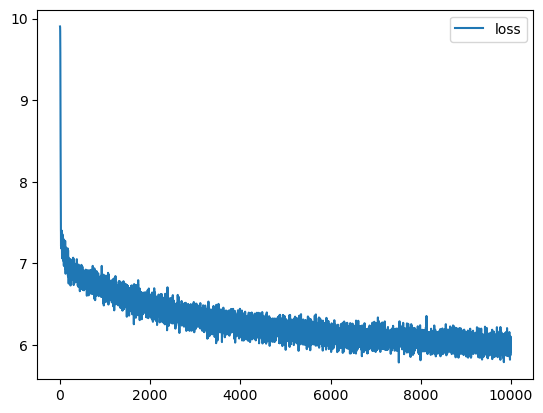

In [48]:
plt.plot(r.history['loss'], label='loss')
plt.legend()

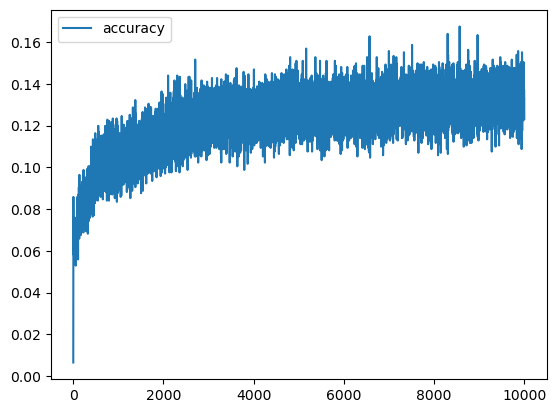

In [49]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.legend()

In [50]:
embeddings = model.layers[1].get_weights()[0]

In [51]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
neighbors.fit(embeddings)

NearestNeighbors(algorithm='ball_tree')

In [52]:
queen_idx = tokenizer.word_index['queen']
queen = embeddings[queen_idx:queen_idx+1]
distances, indices = neighbors.kneighbors(queen)


In [55]:
for idx in indices[0]:
    word = tokenizer.index_word[idx]
    print(word)

queen
elizabeth
mary
prince
princess
